Griffin Shelor\
1-5-2024
### Python for Earth Sciences Final Project

# Forecasting Snow Water Equivalent (SWE) at Three SNOTEL Stations in Alaska from September 2021 - May 2022 using Random Forest modeling and SNOTEL data from January 2010 - May 2021

## Loading packages and reading in dataset

In [28]:
## importing modules/packages
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn

In [29]:
## reading in csv, printing info about it
SnotelDaymet = pd.read_csv("SnotelDaymetAKSubset.csv").dropna()
print(SnotelDaymet.shape)
print(SnotelDaymet.info())

(6396, 34)
<class 'pandas.core.frame.DataFrame'>
Index: 6396 entries, 0 to 6827
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   network                    6396 non-null   object 
 1   state                      6396 non-null   object 
 2   site_name                  6396 non-null   object 
 3   description                6396 non-null   object 
 4   start                      6396 non-null   object 
 5   end                        6396 non-null   object 
 6   latitude                   6396 non-null   float64
 7   longitude                  6396 non-null   float64
 8   elev                       6396 non-null   int64  
 9   county                     6396 non-null   object 
 10  site_id                    6396 non-null   int64  
 11  Year                       6396 non-null   int64  
 12  Month                      6396 non-null   int64  
 13  Day                        6396 non-null  

In [30]:
## printing first 5 rows
SnotelDaymet.head()

,network,state,site_name,description,start,end,latitude,longitude,elev,county,...,daymet_mintemp,daymet_precip,daymet_meantemp,swe_plus,prevday_swe,prevday_maxtemp,prevday_mintemp,prevday_meantemp,prevday_precip,prevday_cumulative_precip
0,SNTL,AK,munson ridge,Rock Creek-Chena River (190803060602),1979-10-01,2024-05-02,64.85,-146.21,945,Fairbanks North Star,...,-3.49,0.00,-1.735,92.4,91.4,1.23,-13.94,-6.355,3.69,86.4
1,SNTL,AK,kenai moose pens,Upper Moose River (190203021601),1982-10-01,2024-05-02,60.73,-150.48,91,Kenai Peninsula,...,0.16,0.00,3.150,44.2,43.2,2.34,-4.98,-1.320,0.00,119.4
2,SNTL,AK,anchor river divide,Headwaters Anchor River (190203010701),1980-10-01,2024-05-02,59.86,-151.32,504,Kenai Peninsula,...,-6.49,0.00,-3.950,214.4,213.4,0.29,-3.49,-1.600,12.35,299.7
3,SNTL,AK,munson ridge,Rock Creek-Chena River (190803060602),1979-10-01,2024-05-02,64.85,-146.21,945,Fairbanks North Star,...,-6.35,0.00,-3.280,92.4,91.4,0.02,-3.49,-1.735,0.00,86.4
4,SNTL,AK,kenai moose pens,Upper Moose River (190203021601),1982-10-01,2024-05-02,60.73,-150.48,91,Kenai Peninsula,...,-1.61,7.94,0.530,44.2,43.2,6.14,0.16,3.150,0.00,119.4


## Subsetting data to be forecasted after model is built

In [31]:
## filtering SnotelDaymet to remove 2023 days being forecasted (September 1 2023 through December 31 2023)
Snotel_fcast = SnotelDaymet[(SnotelDaymet['Year']==2022) & (SnotelDaymet['Month']>=9) & (SnotelDaymet['Day'] >= 1)].copy()
## identifying dependent variable, dropping it and other irrelevant variables from covariates
columns = ['latitude', 'elev', 'prevday_cumulative_precip', 'prevday_maxtemp', 'prevday_mintemp', 'prevday_meantemp', 'prevday_precip']
fcast_covariates = pd.DataFrame(Snotel_fcast, columns=columns)

## subsetting rows not being forecasted so they are not used to build the model
Snotel_ModelData = SnotelDaymet[~SnotelDaymet.isin(Snotel_fcast)]

In [32]:
Snotel_fcast.head()

,network,state,site_name,description,start,end,latitude,longitude,elev,county,...,daymet_mintemp,daymet_precip,daymet_meantemp,swe_plus,prevday_swe,prevday_maxtemp,prevday_mintemp,prevday_meantemp,prevday_precip,prevday_cumulative_precip
6711,SNTL,AK,munson ridge,Rock Creek-Chena River (190803060602),1979-10-01,2024-05-02,64.85,-146.21,945,Fairbanks North Star,...,0.70,13.36,2.510,1.0,0.0,7.66,3.02,5.340,11.91,581.7
6712,SNTL,AK,munson ridge,Rock Creek-Chena River (190803060602),1979-10-01,2024-05-02,64.85,-146.21,945,Fairbanks North Star,...,-0.30,0.00,4.305,1.0,0.0,4.32,0.70,2.510,13.36,589.3
6713,SNTL,AK,munson ridge,Rock Creek-Chena River (190803060602),1979-10-01,2024-05-02,64.85,-146.21,945,Fairbanks North Star,...,4.09,9.15,5.590,1.0,0.0,8.91,-0.30,4.305,0.00,594.4
6714,SNTL,AK,munson ridge,Rock Creek-Chena River (190803060602),1979-10-01,2024-05-02,64.85,-146.21,945,Fairbanks North Star,...,3.61,0.00,7.120,1.0,0.0,7.09,4.09,5.590,9.15,604.5
6715,SNTL,AK,munson ridge,Rock Creek-Chena River (190803060602),1979-10-01,2024-05-02,64.85,-146.21,945,Fairbanks North Star,...,2.54,2.70,4.025,1.0,0.0,10.63,3.61,7.120,0.00,635.0


In [33]:
Snotel_ModelData.head()

,network,state,site_name,description,start,end,latitude,longitude,elev,county,...,daymet_mintemp,daymet_precip,daymet_meantemp,swe_plus,prevday_swe,prevday_maxtemp,prevday_mintemp,prevday_meantemp,prevday_precip,prevday_cumulative_precip
0,SNTL,AK,munson ridge,Rock Creek-Chena River (190803060602),1979-10-01,2024-05-02,64.85,-146.21,945.0,Fairbanks North Star,...,-3.49,0.00,-1.735,92.4,91.4,1.23,-13.94,-6.355,3.69,86.4
1,SNTL,AK,kenai moose pens,Upper Moose River (190203021601),1982-10-01,2024-05-02,60.73,-150.48,91.0,Kenai Peninsula,...,0.16,0.00,3.150,44.2,43.2,2.34,-4.98,-1.320,0.00,119.4
2,SNTL,AK,anchor river divide,Headwaters Anchor River (190203010701),1980-10-01,2024-05-02,59.86,-151.32,504.0,Kenai Peninsula,...,-6.49,0.00,-3.950,214.4,213.4,0.29,-3.49,-1.600,12.35,299.7
3,SNTL,AK,munson ridge,Rock Creek-Chena River (190803060602),1979-10-01,2024-05-02,64.85,-146.21,945.0,Fairbanks North Star,...,-6.35,0.00,-3.280,92.4,91.4,0.02,-3.49,-1.735,0.00,86.4
4,SNTL,AK,kenai moose pens,Upper Moose River (190203021601),1982-10-01,2024-05-02,60.73,-150.48,91.0,Kenai Peninsula,...,-1.61,7.94,0.530,44.2,43.2,6.14,0.16,3.150,0.00,119.4


# Creating training and testing datasets

In [34]:
## identifying dependent variable, dropping it from covariates
columns = ['latitude','elev', 'prevday_cumulative_precip', 'prevday_maxtemp', 'prevday_mintemp', 'prevday_meantemp', 'prevday_precip']
x_covariates = pd.DataFrame(Snotel_ModelData, columns=columns).dropna()
y_swe = Snotel_ModelData['snow_water_equivalent'].dropna()
#  setting 1/4 of the data aside for model testing
x_train, x_test, y_train, y_test = train_test_split(x_covariates, y_swe, test_size=0.25, random_state=802)

The code chunk below wouldn't run for some reason unless I added the dropna to the middle lines in the above chunk? I'm not sure why this is, I can run a random forest model just fine in R with the exact same csv

In [35]:
# Fit model to training data, evaluate performance on test dataset
SWEmodel_rf = RandomForestRegressor(max_depth=3, n_estimators=10000, random_state=802)
SWEmodel_rf_fit = SWEmodel_rf.fit(x_train, y_train)
## predicting on test dataset
ymodel_rf = SWEmodel_rf_fit.predict(x_test)
print(r2_score(y_test, ymodel_rf))

0.41045866674391196


In [36]:
# Add prediction for forecasted data points
swe_forecast = SWEmodel_rf.predict(fcast_covariates)

Snotel_fcast['swe_forecast'] = swe_forecast


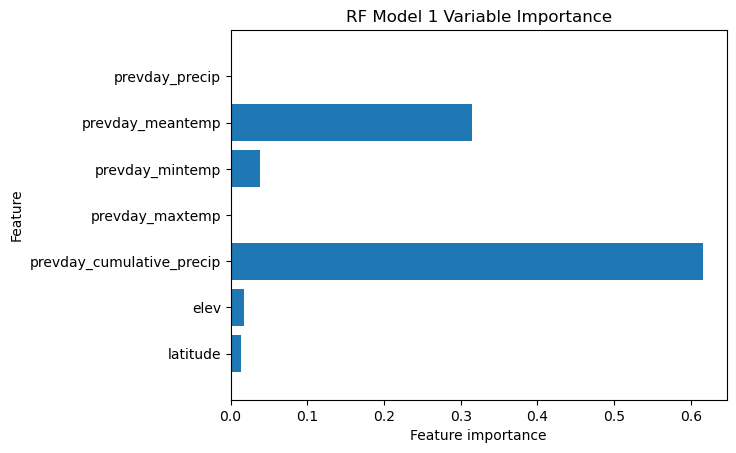

In [61]:
# Plot the feature importance
n_features= SWEmodel_rf.n_features_in_
plt.barh(np.arange(n_features), SWEmodel_rf.feature_importances_, align='center')
plt.title("RF Model 1 Variable Importance")
plt.yticks(np.arange(n_features), x_covariates.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features);
plt.savefig('Model1VarImp.png',dpi=300)

In [51]:
## printing r2 score and RMSE on for model compared to test data, as well as model compared to true forecast
print('Random Forest Regression r2_score = {:4.2f}'.format(r2_score(y_test, ymodel_rf)))
print('Random Forest Regression RMSE score on test dataset = {:4.2f}'.format(root_mean_squared_error(y_test, ymodel_rf)))
print('Random Forest Regression RMSE score on forecasted 2021-2022 data = {:4.2f}'.format(root_mean_squared_error(Snotel_fcast['swe_forecast'], Snotel_fcast['snow_water_equivalent'])))

Random Forest Regression r2_score = 0.41
Random Forest Regression RMSE score on test dataset = 92.22
Random Forest Regression RMSE score on forecasted 2021-2022 data = 81.54


## Random Forest Model 2, dropping unimportant features

In [39]:
## identifying dependent variable, dropping it and other irrelevant variables from covariates in forecasted days
columns_mod2 = ['prevday_cumulative_precip', 'prevday_mintemp', 'prevday_meantemp']
fcast_covariates_mod2 = pd.DataFrame(Snotel_fcast, columns=columns_mod2)
x_covariates_mod2 = pd.DataFrame(Snotel_ModelData, columns=columns_mod2).dropna()
y_swe_mod2 = Snotel_ModelData['snow_water_equivalent'].dropna()
#  the same proportions of examples in each class
x_train_mod2, x_test_mod2, y_train_mod2, y_test_mod2 = train_test_split(x_covariates_mod2, y_swe_mod2, test_size=0.25, random_state=802)


In [40]:
## fitting 2nd model with different covariates
# Fit model to training data, evaluate performance on test dataset
SWEmodel_rf_mod2 = RandomForestRegressor(max_depth=3, n_estimators=10000, random_state=802)
SWEmodel_rf_fit_mod2 = SWEmodel_rf_mod2.fit(x_train_mod2, y_train_mod2)
## predicting on test dataset
ymodel_rf_mod2 = SWEmodel_rf_fit_mod2.predict(x_test_mod2)
print(r2_score(y_test_mod2, ymodel_rf_mod2))

0.40308497735735105


In [41]:
# Add prediction for forecasted data points
swe_forecast_mod2 = SWEmodel_rf_mod2.predict(fcast_covariates_mod2)

Snotel_fcast['swe_forecast_mod2'] = swe_forecast_mod2

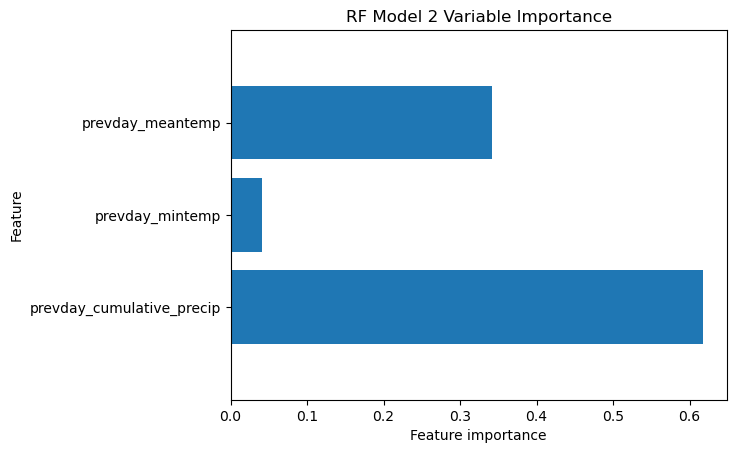

In [57]:
# Plot the feature importance
n_features_mod2 = SWEmodel_rf_mod2.n_features_in_
plt.barh(np.arange(n_features_mod2), SWEmodel_rf_mod2.feature_importances_, align='center')
plt.title("RF Model 2 Variable Importance")
plt.yticks(np.arange(n_features_mod2), x_covariates_mod2.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features_mod2);
plt.savefig('Model2VarImp.png',dpi=300)

### Evaluating r2 score and RMSE of 2nd model

In [50]:
## printing r2 score and RMSE on for model compared to test data, as well as model compared to true forecast
print('Random Forest Model 2 Regression r2_score = {:4.2f}'.format(r2_score(y_test_mod2, ymodel_rf_mod2)))
print('Random Forest Model 2 Regression RMSE score on test dataset = {:4.2f}'.format(root_mean_squared_error(y_test_mod2, ymodel_rf_mod2)))
print('Random Forest Model 2 Regression RMSE score on forecasted 2021-2022 data = {:4.2f}'.format(root_mean_squared_error(Snotel_fcast['swe_forecast_mod2'], Snotel_fcast['snow_water_equivalent'])))

Random Forest Model 2 Regression r2_score = 0.40
Random Forest Model 2 Regression RMSE score on test dataset = 92.80
Random Forest Model 2 Regression RMSE score on forecasted 2021-2022 data = 81.14


### Adjusting Hyper paramters of model 2 to see if it continues to perform better

In [44]:
## Model 3
## Adjusting hyperparameters of model 2, using same covariates as model 2
# cumulative precipitation, mean temp, min temp
# Fit model to training data, evaluate performance on test dataset
# using same training data, just changing hyper parameters
SWEmodel_rf_mod3 = RandomForestRegressor(max_depth=2, n_estimators=5000, random_state=802)
SWEmodel_rf_fit_mod3 = SWEmodel_rf_mod3.fit(x_train_mod2, y_train_mod2)
## predicting on test dataset
ymodel_rf_mod3 = SWEmodel_rf_fit_mod3.predict(x_test_mod2)

# Add prediction for forecasted data points
swe_forecast_mod3 = SWEmodel_rf_fit_mod3.predict(fcast_covariates_mod2)

Snotel_fcast['swe_forecast_mod3'] = swe_forecast_mod3


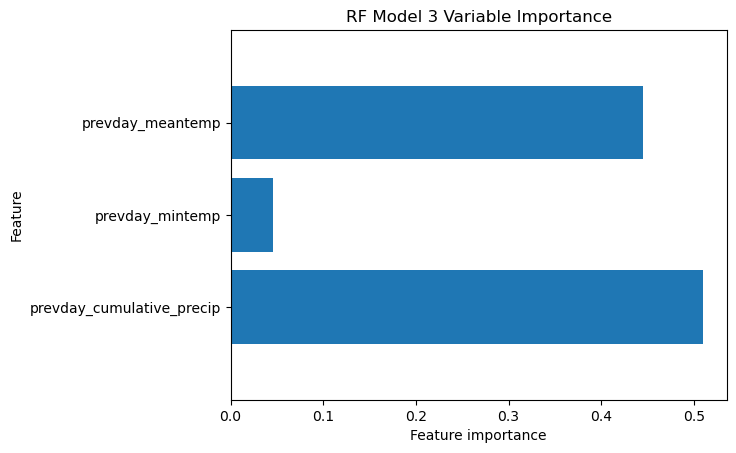

In [58]:
# Plot the feature importance
n_features_mod3 = SWEmodel_rf_fit_mod3.n_features_in_
plt.barh(np.arange(n_features_mod3), SWEmodel_rf_fit_mod3.feature_importances_, align='center')
plt.title("RF Model 3 Variable Importance")
plt.yticks(np.arange(n_features_mod3), x_covariates_mod2.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features_mod3);
plt.savefig('Model3VarImp.png',dpi=300)

Evaluating R2 score and RMSE of 3rd model (2nd model but with adjusted hyperparameters)

In [64]:
## printing r2 score and RMSE on for model compared to test data, as well as model compared to true forecast
## y_test_mod2 can remain because the train/test split was not changed for the 3rd model
print('Random Forest Model 3 Regression r2_score = {:4.2f}'.format(r2_score(y_test_mod2, ymodel_rf_mod3)))
print('Random Forest Model 3 Regression RMSE score on test dataset = {:4.2f}'.format(root_mean_squared_error(y_test_mod2, ymodel_rf_mod3)))
print('Random Forest Model 3 Regression RMSE score on forecasted 2022-2023 data = {:4.2f}'.format(root_mean_squared_error(Snotel_fcast['swe_forecast_mod3'], Snotel_fcast['snow_water_equivalent'])))

Random Forest Model 3 Regression r2_score = 0.30
Random Forest Model 3 Regression RMSE score on test dataset = 100.43
Random Forest Model 3 Regression RMSE score on forecasted 2022-2023 data = 71.87


### Model 4: Again using the same train and test data as Model 2 but with increased hyperparameters

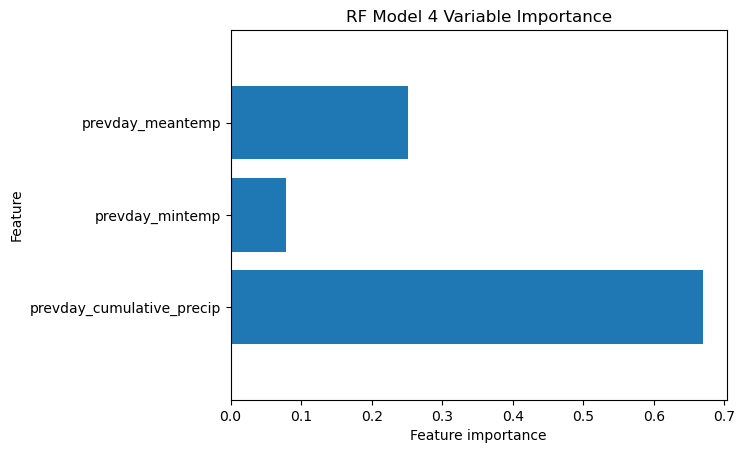

In [53]:
## Model 3
## Adjusting hyperparameters of model 2, using same covariates as model 2
# cumulative precipitation, mean temp, min temp
# Fit model to training data, evaluate performance on test dataset
# using same training data, just changing hyper parameters
SWEmodel_rf_mod4 = RandomForestRegressor(max_depth=5, n_estimators=25000, random_state=802)
SWEmodel_rf_fit_mod4 = SWEmodel_rf_mod4.fit(x_train_mod2, y_train_mod2)
## predicting on test dataset
ymodel_rf_mod4 = SWEmodel_rf_fit_mod4.predict(x_test_mod2)

# Add prediction for forecasted data points
swe_forecast_mod4 = SWEmodel_rf_fit_mod4.predict(fcast_covariates_mod2)

Snotel_fcast['swe_forecast_mod4'] = swe_forecast_mod4

# Plot the feature importance
n_features_mod4 = SWEmodel_rf_fit_mod4.n_features_in_
plt.barh(np.arange(n_features_mod4), SWEmodel_rf_fit_mod4.feature_importances_, align='center')
plt.title("RF Model 4 Variable Importance")
plt.yticks(np.arange(n_features_mod4), x_covariates_mod2.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features_mod4);
plt.savefig('Model4VarImp.png',dpi=300)

In [63]:
## printing r2 score and RMSE on for model compared to test data, as well as model compared to true forecast
## y_test_mod2 can remain because the train/test split was not changed for the 3rd model
print('Random Forest Model 4 Regression r2_score = {:4.2f}'.format(r2_score(y_test_mod2, ymodel_rf_mod4)))
print('Random Forest Model 4 Regression RMSE score on test dataset = {:4.2f}'.format(root_mean_squared_error(y_test_mod2, ymodel_rf_mod4)))
print('Random Forest Model 4 Regression RMSE score on forecasted 2021-2022 data = {:4.2f}'.format(root_mean_squared_error(Snotel_fcast['swe_forecast_mod4'], Snotel_fcast['snow_water_equivalent'])))

Random Forest Model 4 Regression r2_score = 0.53
Random Forest Model 4 Regression RMSE score on test dataset = 82.02
Random Forest Model 4 Regression RMSE score on forecasted 2021-2022 data = 37.62
